# TATA Consumer Products Stock Price Prediction using K-Nearest Neighbors (KNN)

## Project Overview
This notebook demonstrates how to predict stock price movements using the K-Nearest Neighbors (KNN) machine learning algorithm. We'll analyze TATA Consumer Products stock data and build both classification and regression models to predict future price movements.

### What you'll learn:
- How to fetch stock data from Yahoo Finance
- Data preprocessing and feature engineering
- Building and optimizing KNN models
- Evaluating model performance
- Making predictions about stock price movements

### Prerequisites:
- Basic understanding of Python
- Familiarity with pandas and numpy
- Basic knowledge of machine learning concepts

## 1. Import Required Libraries

First, we'll import all the necessary libraries for data manipulation, visualization, and machine learning.

In [3]:
# Core data manipulation and numerical libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Other utilities
import warnings
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
plt.style.use('default')  # Changed from deprecated 'seaborn-v0_8'
sns.set_palette("husl")

In [4]:
# Install yfinance library for downloading stock data
import subprocess
import sys

try:
    import yfinance
    print("yfinance is already installed")
except ImportError:
    print("Installing yfinance...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    print("yfinance installed successfully")

yfinance is already installed


## 2. Data Collection

We'll use the `yfinance` library to download stock data for TATA Consumer Products from Yahoo Finance. First, let's install and import the library.

In [5]:
# Import yfinance library
import yfinance as yf
import pandas as pd  # Import pandas for DataFrame manipulation

# Download TATA Consumer Products stock data
# Using a longer time period (3 years) for better model training
ticker = "TATACONSUM.NS"  # TATA Consumer Products on NSE
start_date = "2022-01-01"
end_date = "2024-12-31"

print(f"Downloading stock data for {ticker} from {start_date} to {end_date}")
df = yf.download(ticker, start=start_date, end=end_date)

# Robust fix for MultiIndex column structure
print(f"Original columns: {df.columns}")
print(f"Column type: {type(df.columns)}")

if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detected - flattening...")
    df.columns = df.columns.droplevel(1)  # Remove the ticker level
    print(f"After flattening: {df.columns}")

# Alternative approach if still MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    print("Still MultiIndex - using alternative flattening...")
    df.columns = df.columns.get_level_values(0)

# Ensure we have proper column names
expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
if not all(col in df.columns for col in expected_columns):
    print("Warning: Some expected columns are missing!")
    print(f"Available columns: {list(df.columns)}")

print(f"\nFinal data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Column names: {df.columns.tolist()}")
print("\nFirst 5 rows of the data:")
print(df.head())

[*********************100%***********************]  1 of 1 completed

Original columns: MultiIndex([( 'Close', 'TATACONSUM.NS'),
            (  'High', 'TATACONSUM.NS'),
            (   'Low', 'TATACONSUM.NS'),
            (  'Open', 'TATACONSUM.NS'),
            ('Volume', 'TATACONSUM.NS')],
           names=['Price', 'Ticker'])
Column type: <class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex detected - flattening...
After flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

Final data shape: (738, 5)
Date range: 2022-01-03 00:00:00 to 2024-12-30 00:00:00
Column names: ['Close', 'High', 'Low', 'Open', 'Volume']

First 5 rows of the data:
Price            Close        High         Low        Open   Volume
Date                                                               
2022-01-03  723.727478  725.082072  715.987077  722.759928   925699
2022-01-04  714.874390  732.145195  707.327510  727.597697  2352482
2022-01-05  709.794800  719.373570  702.925217  716.229032  2076552
2022-01-06  701.909241  711.100967  6

In [6]:
# Debug: Check column structure and fix if needed
print("=== DEBUGGING COLUMN STRUCTURE ===")
print(f"DataFrame columns type: {type(df.columns)}")
print(f"DataFrame columns: {df.columns}")

# Check if columns are MultiIndex and flatten if needed
if isinstance(df.columns, pd.MultiIndex):
    print("MultiIndex detected - flattening columns...")
    df.columns = df.columns.droplevel(1)
    print(f"After flattening: {df.columns}")
else:
    print("Columns are already flat")

# Verify that Close is a Series, not DataFrame
print(f"\nType of df['Close']: {type(df['Close'])}")
print(f"Shape of df['Close']: {df['Close'].shape}")

# Display sample data to confirm structure
print(f"\nSample Close prices:")
print(df['Close'].head())

print("=== DEBUG COMPLETE ===\n")

=== DEBUGGING COLUMN STRUCTURE ===
DataFrame columns type: <class 'pandas.core.indexes.base.Index'>
DataFrame columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Columns are already flat

Type of df['Close']: <class 'pandas.core.series.Series'>
Shape of df['Close']: (738,)

Sample Close prices:
Date
2022-01-03    723.727478
2022-01-04    714.874390
2022-01-05    709.794800
2022-01-06    701.909241
2022-01-07    712.213684
Name: Close, dtype: float64
=== DEBUG COMPLETE ===



In [7]:
# Display basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print("\nFirst 10 rows:")
df.head(10)

Dataset Info:
Shape: (738, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data types:
Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Missing values:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

First 10 rows:


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,723.727478,725.082072,715.987077,722.759928,925699
2022-01-04,714.874390,732.145195,707.327510,727.597697,2352482
2022-01-05,709.794800,719.373570,702.925217,716.229032,2076552
2022-01-06,701.909241,711.100967,699.103322,709.214232,2077754
2022-01-07,712.213684,720.486286,701.522266,701.909310,2107056
2022-01-10,708.149963,718.889746,707.279145,716.422505,1592097
2022-01-11,714.680908,719.470234,707.037239,712.552286,1905347
2022-01-12,712.213684,719.180057,709.359458,718.889804,1817215
2022-01-13,706.505127,715.454966,700.119261,713.084456,1604671


## 3. Data Exploration and Analysis

Let's explore our dataset to understand the structure and characteristics of the stock data.

In [8]:
# Statistical summary of the data
print("Statistical Summary:")
df.describe()

Statistical Summary:


Price,Close,High,Low,Open,Volume
count,738.000000,738.000000,738.000000,738.000000,7.380000e+02
mean,883.469762,893.049495,873.965946,884.206580,1.690090e+06
std,170.753619,172.663024,168.575824,171.095183,1.293538e+06
min,638.437927,651.645010,629.101104,637.615533,2.127720e+05
25%,742.943268,751.818719,737.988661,743.093472,9.606695e+05
50%,828.603790,834.814658,820.643056,828.110891,1.293944e+06
75%,1075.681549,1085.564647,1062.594402,1075.656907,2.000114e+06
max,1243.694458,1251.038935,1204.423454,1245.123857,1.535813e+07


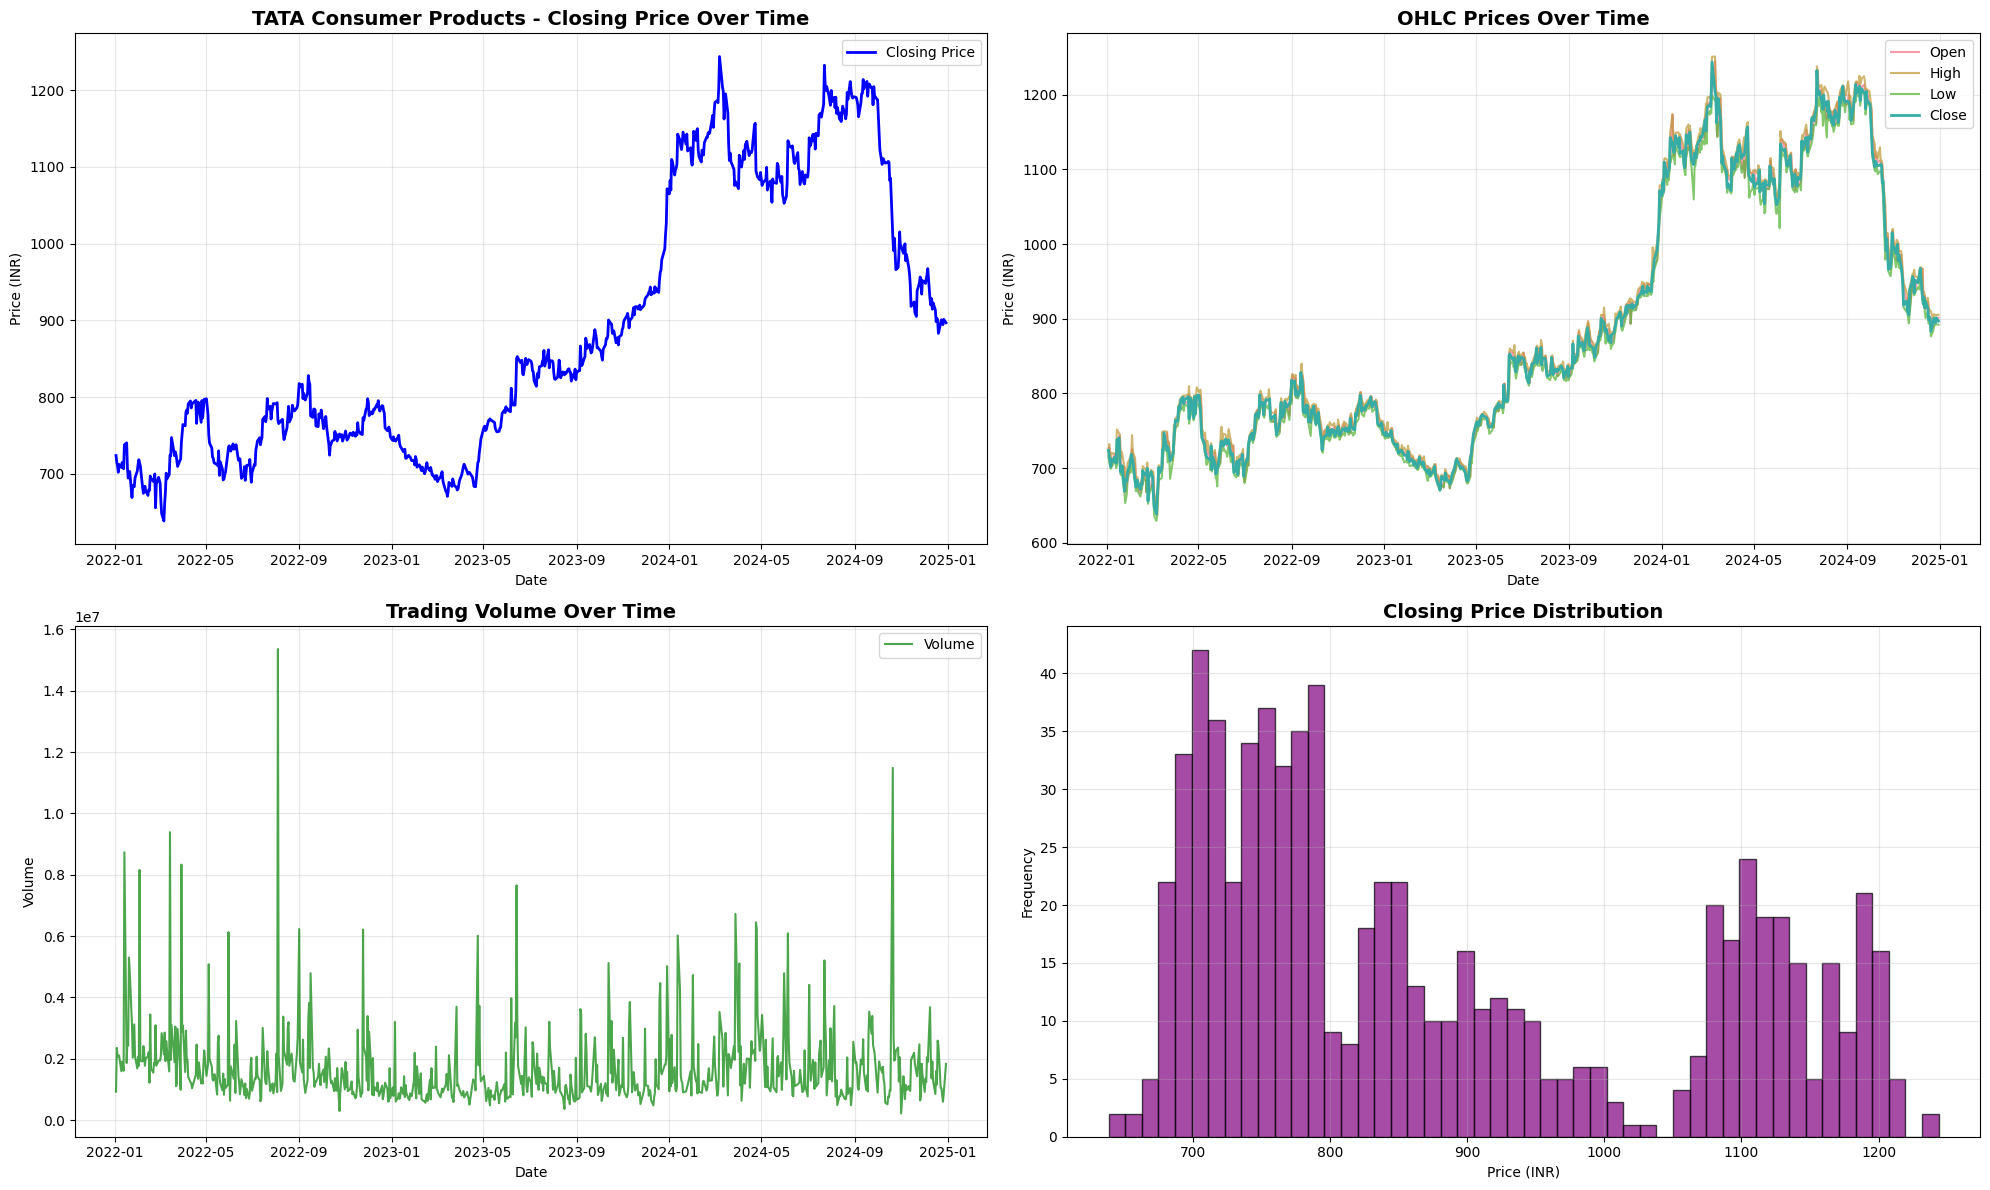

In [9]:
# Create comprehensive stock price visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Closing price over time
axes[0, 0].plot(df.index, df['Close'], label='Closing Price', color='blue', linewidth=2)
axes[0, 0].set_title('TATA Consumer Products - Closing Price Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (INR)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. All prices (OHLC)
axes[0, 1].plot(df.index, df['Open'], label='Open', alpha=0.7)
axes[0, 1].plot(df.index, df['High'], label='High', alpha=0.7)
axes[0, 1].plot(df.index, df['Low'], label='Low', alpha=0.7)
axes[0, 1].plot(df.index, df['Close'], label='Close', linewidth=2)
axes[0, 1].set_title('OHLC Prices Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price (INR)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Trading volume
axes[1, 0].plot(df.index, df['Volume'], label='Volume', color='green', alpha=0.7)
axes[1, 0].set_title('Trading Volume Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Volume')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Price distribution
axes[1, 1].hist(df['Close'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('Closing Price Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Price (INR)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Data Visualization

Visualizing the stock data helps us understand price trends and patterns.

In [10]:
# Create a copy to preserve original data
df_features = df.copy()

# Safety check: Ensure columns are Series, not DataFrames
print("=== FEATURE ENGINEERING SAFETY CHECKS ===")
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    if col in df.columns:
        print(f"{col} type: {type(df[col])}, shape: {df[col].shape}")
        # If it's a DataFrame with one column, convert to Series
        if isinstance(df[col], pd.DataFrame):
            print(f"Converting {col} from DataFrame to Series")
            df[col] = df[col].iloc[:, 0]
            df_features[col] = df[col]

print("=== STARTING FEATURE ENGINEERING ===\n")

# Basic price differences
df_features['open_close'] = df['Open'] - df['Close']  # Intraday price movement
df_features['high_low'] = df['High'] - df['Low']      # Daily volatility

# Percentage changes (more robust than absolute differences)
df_features['open_close_pct'] = (df['Open'] - df['Close']) / df['Close'] * 100
df_features['high_low_pct'] = (df['High'] - df['Low']) / df['Close'] * 100

# Technical indicators
# 1. Moving averages
df_features['ma_5'] = df['Close'].rolling(window=5).mean()
df_features['ma_10'] = df['Close'].rolling(window=10).mean()
df_features['ma_20'] = df['Close'].rolling(window=20).mean()

# 2. Price relative to moving averages
df_features['close_ma5_ratio'] = df['Close'] / df_features['ma_5']
df_features['close_ma10_ratio'] = df['Close'] / df_features['ma_10']
df_features['close_ma20_ratio'] = df['Close'] / df_features['ma_20']

# 3. Volume indicators
df_features['volume_ma_10'] = df['Volume'].rolling(window=10).mean()
df_features['volume_ratio'] = df['Volume'] / df_features['volume_ma_10']

# 4. Volatility indicators
df_features['price_volatility'] = df['Close'].rolling(window=10).std()
df_features['volume_volatility'] = df['Volume'].rolling(window=10).std()

# 5. Price momentum
df_features['price_change_1d'] = df['Close'].pct_change(1)
df_features['price_change_3d'] = df['Close'].pct_change(3)
df_features['price_change_5d'] = df['Close'].pct_change(5)

# 6. RSI-like indicator (simplified)
df_features['price_position'] = (df['Close'] - df['Low'].rolling(14).min()) / (df['High'].rolling(14).max() - df['Low'].rolling(14).min())

# Remove rows with NaN values
df_features = df_features.dropna()

print(f"Original dataset shape: {df.shape}")
print(f"Feature-engineered dataset shape: {df_features.shape}")
print(f"Number of features created: {len(df_features.columns) - len(df.columns)}")
print(f"\nNew features: {[col for col in df_features.columns if col not in df.columns]}")
print("\n=== FEATURE ENGINEERING COMPLETED SUCCESSFULLY ===")

=== FEATURE ENGINEERING SAFETY CHECKS ===
Open type: <class 'pandas.core.series.Series'>, shape: (738,)
High type: <class 'pandas.core.series.Series'>, shape: (738,)
Low type: <class 'pandas.core.series.Series'>, shape: (738,)
Close type: <class 'pandas.core.series.Series'>, shape: (738,)
Volume type: <class 'pandas.core.series.Series'>, shape: (738,)
=== STARTING FEATURE ENGINEERING ===

Original dataset shape: (738, 5)
Feature-engineered dataset shape: (719, 23)
Number of features created: 18

New features: ['open_close', 'high_low', 'open_close_pct', 'high_low_pct', 'ma_5', 'ma_10', 'ma_20', 'close_ma5_ratio', 'close_ma10_ratio', 'close_ma20_ratio', 'volume_ma_10', 'volume_ratio', 'price_volatility', 'volume_volatility', 'price_change_1d', 'price_change_3d', 'price_change_5d', 'price_position']

=== FEATURE ENGINEERING COMPLETED SUCCESSFULLY ===


## 5. Feature Engineering

We'll create additional features that can help improve our model's prediction accuracy. These features capture important market dynamics.

In [11]:
# Display the enhanced dataset with engineered features
print("Enhanced dataset with engineered features:")
print(f"Shape: {df_features.shape}")
print("\nFirst 5 rows of key features:")
feature_cols = ['Close', 'open_close', 'high_low', 'open_close_pct', 'high_low_pct', 
                'close_ma5_ratio', 'volume_ratio', 'price_change_1d']
df_features[feature_cols].head()

Enhanced dataset with engineered features:
Shape: (719, 23)

First 5 rows of key features:


Price,Close,open_close,high_low,open_close_pct,high_low_pct,close_ma5_ratio,volume_ratio,price_change_1d
Date,,,,,,,,
2022-01-31,703.699219,-1.257803,14.416521,-0.178742,2.048677,1.024265,0.577566,0.013094
2022-02-01,712.213684,-3.966932,21.237739,-0.556986,2.981934,1.023783,0.703474,0.012100
2022-02-02,718.357605,-0.822453,9.965814,-0.114491,1.387305,1.022743,0.623188,0.008627
2022-02-03,714.148682,11.513869,34.493184,1.612251,4.829972,1.007824,2.386872,-0.005859
2022-02-04,709.988281,6.966373,23.559822,0.981195,3.318340,0.997621,0.627240,-0.005826


In [12]:
# Select comprehensive features for better model performance
feature_columns = [
    'open_close', 'high_low',                    # Basic price movements
    'open_close_pct', 'high_low_pct',            # Percentage movements
    'close_ma5_ratio', 'close_ma10_ratio',       # Moving average ratios
    'volume_ratio',                              # Volume indicators
    'price_volatility',                          # Volatility
    'price_change_1d', 'price_change_3d',        # Short-term momentum
    'price_position'                             # RSI-like indicator
]

# Create feature matrix X
X = df_features[feature_columns].copy()

print(f"Selected features: {feature_columns}")
print(f"Feature matrix shape: {X.shape}")
print(f"\nFeature correlation with target (next day return):")

# Calculate next day return for correlation analysis
next_day_return = df_features['Close'].pct_change().shift(-1)
correlations = X.corrwith(next_day_return).sort_values(key=abs, ascending=False)
print(correlations)

print("\nFirst 5 rows of feature matrix:")
X.head()

Selected features: ['open_close', 'high_low', 'open_close_pct', 'high_low_pct', 'close_ma5_ratio', 'close_ma10_ratio', 'volume_ratio', 'price_volatility', 'price_change_1d', 'price_change_3d', 'price_position']
Feature matrix shape: (719, 11)

Feature correlation with target (next day return):
Price
price_change_1d    -0.074043
open_close          0.071266
open_close_pct      0.068646
price_change_3d    -0.058628
close_ma5_ratio    -0.057569
close_ma10_ratio   -0.046233
volume_ratio       -0.039174
high_low           -0.022708
price_position     -0.020727
price_volatility    0.015168
high_low_pct       -0.003343
dtype: float64

First 5 rows of feature matrix:


Price,open_close,high_low,open_close_pct,high_low_pct,close_ma5_ratio,close_ma10_ratio,volume_ratio,price_volatility,price_change_1d,price_change_3d,price_position
Date,,,,,,,,,,,
2022-01-31,-1.257803,14.416521,-0.178742,2.048677,1.024265,1.008102,0.577566,18.873515,0.013094,0.027623,0.512745
2022-02-01,-3.966932,21.237739,-0.556986,2.981934,1.023783,1.024417,0.703474,13.100793,0.012100,0.042708,0.599020
2022-02-02,-0.822453,9.965814,-0.114491,1.387305,1.022743,1.031675,0.623188,14.576242,0.008627,0.034197,0.661275
2022-02-03,11.513869,34.493184,1.612251,4.829972,1.007824,1.022724,2.386872,15.591242,-0.005859,0.014849,0.618627
2022-02-04,6.966373,23.559822,0.981195,3.318340,0.997621,1.015310,0.627240,16.027574,-0.005826,-0.003125,0.610275


## 6. Model Preparation

Now we'll prepare our features (X) and target variables (y) for both classification and regression tasks.

In [13]:
# Create target variable for classification
# Predict if next day's closing price will be higher (1) or lower (-1) than today's
y_classification = np.where(df_features['Close'].shift(-1) > df_features['Close'], 1, -1)

# Create target variable for regression
# Predict the actual next day's closing price
y_regression = df_features['Close'].shift(-1)

# Remove the last row since we don't have next day's price for it
X = X[:-1]
y_classification = y_classification[:-1]
y_regression = y_regression[:-1]

print(f"Classification target distribution:")
print(f"Up days (1): {np.sum(y_classification == 1)} ({np.mean(y_classification == 1)*100:.1f}%)")
print(f"Down days (-1): {np.sum(y_classification == -1)} ({np.mean(y_classification == -1)*100:.1f}%)")

print(f"\nRegression target statistics:")
print(f"Min price: {np.min(y_regression):.2f}")
print(f"Max price: {np.max(y_regression):.2f}")
print(f"Mean price: {np.mean(y_regression):.2f}")

print(f"\nFinal dataset shape: X={X.shape}, y_class={y_classification.shape}, y_reg={y_regression.shape}")

# Show first few examples
print(f"\nFirst 10 classification targets: {y_classification[:10]}")
print(f"First 5 regression targets: {y_regression[:5].round(2)}")

Classification target distribution:
Up days (1): 362 (50.4%)
Down days (-1): 356 (49.6%)

Regression target statistics:
Min price: 638.44
Max price: 1243.69
Mean price: 888.41

Final dataset shape: X=(718, 11), y_class=(718,), y_reg=(718,)

First 10 classification targets: [ 1  1 -1 -1 -1 -1  1  1 -1 -1]
First 5 regression targets: Date
2022-01-31    712.21
2022-02-01    718.36
2022-02-02    714.15
2022-02-03    709.99
2022-02-04    681.93
Name: Close, dtype: float64


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Split data into training and testing sets
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, test_size=0.25, random_state=42, stratify=y_classification
)

# Same split for regression
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.25, random_state=42
)

print(f"Training set shape: X_train={X_train.shape}, y_train_class={y_train_class.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test_class={y_test_class.shape}")

# Standardize features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling completed.")
print(f"Original feature ranges (training set):")
print(f"Min: {X_train.min().min():.4f}, Max: {X_train.max().max():.4f}")
print(f"Scaled feature ranges (training set):")
print(f"Min: {X_train_scaled.min():.4f}, Max: {X_train_scaled.max():.4f}")

# Check class distribution in train/test sets
print(f"\nTraining set class distribution:")
print(f"Up days: {np.sum(y_train_class == 1)} ({np.mean(y_train_class == 1)*100:.1f}%)")
print(f"Down days: {np.sum(y_train_class == -1)} ({np.mean(y_train_class == -1)*100:.1f}%)")

print(f"\nTesting set class distribution:")
print(f"Up days: {np.sum(y_test_class == 1)} ({np.mean(y_test_class == 1)*100:.1f}%)")
print(f"Down days: {np.sum(y_test_class == -1)} ({np.mean(y_test_class == -1)*100:.1f}%)")

Training set shape: X_train=(538, 11), y_train_class=(538,)
Testing set shape: X_test=(180, 11), y_test_class=(180,)

Feature scaling completed.
Original feature ranges (training set):
Min: -41.0812, Max: 72.5622
Scaled feature ranges (training set):
Min: -4.6976, Max: 7.7255

Training set class distribution:
Up days: 271 (50.4%)
Down days: 267 (49.6%)

Testing set class distribution:
Up days: 91 (50.6%)
Down days: 89 (49.4%)


## 7. Data Preprocessing and Scaling

KNN is sensitive to the scale of features, so we'll standardize our features for optimal performance.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np

# KNN Classification Model
print("=== KNN CLASSIFICATION MODEL ===\n")

# Extended parameter grid for better optimization
param_grid_class = {
    'n_neighbors': list(range(3, 21)),  # Test more neighbors
    'weights': ['uniform', 'distance'],  # Different weighting schemes
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Different distance metrics
    'p': [1, 2]  # For minkowski metric
}

# Create KNN classifier
knn_classifier = KNeighborsClassifier()

# Use GridSearchCV with cross-validation
print("Performing hyperparameter tuning...")
grid_search_class = GridSearchCV(
    knn_classifier, 
    param_grid_class, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the model with our stock data
grid_search_class.fit(X_train_scaled, y_train_class)

# Get the best model
best_knn_class = grid_search_class.best_estimator_

print(f"\nBest parameters: {grid_search_class.best_params_}")
print(f"Best cross-validation score: {grid_search_class.best_score_:.4f}")

# Make predictions
y_pred_train_class = best_knn_class.predict(X_train_scaled)
y_pred_test_class = best_knn_class.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train_class, y_pred_train_class)
test_accuracy = accuracy_score(y_test_class, y_pred_test_class)

print(f"\n=== CLASSIFICATION RESULTS ===")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Accuracy Improvement: {(test_accuracy - 0.5)*100:.2f}% above random guessing")

# Detailed classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test_class, y_pred_test_class, target_names=['Down', 'Up']))

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_test_class)
print(f"\n=== CONFUSION MATRIX ===")
print("Predicted:  Down  Up")
print(f"Actual Down: {cm[0,0]:4d} {cm[0,1]:3d}")
print(f"Actual Up:   {cm[1,0]:4d} {cm[1,1]:3d}")

# Cross-validation analysis
print(f"\n=== CROSS-VALIDATION ANALYSIS ===")
cv_scores = cross_val_score(best_knn_class, X_train_scaled, y_train_class, cv=5)
print(f"CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== KNN CLASSIFICATION MODEL ===

Performing hyperparameter tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Best cross-validation score: 0.5204

=== CLASSIFICATION RESULTS ===
Training Accuracy: 0.6747 (67.47%)
Testing Accuracy: 0.5333 (53.33%)
Accuracy Improvement: 3.33% above random guessing

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Down       0.52      0.71      0.60        89
          Up       0.56      0.36      0.44        91

    accuracy                           0.53       180
   macro avg       0.54      0.54      0.52       180
weighted avg       0.54      0.53      0.52       180


=== CONFUSION MATRIX ===
Predicted:  Down  Up
Actual Down:   63  26
Actual Up:     58  33

=== CROSS-VALIDATION ANALYSIS ===
CV Scores: [0.5462963  0.5462963  0.48148148 0.51401869 0.51401869]
CV Mean: 0.5204 (+/- 0.0485)

## 8. KNN Classification Model

We'll build a KNN classifier to predict whether the stock price will go up or down the next day.

First 10 predictions:
   Actual Class  Predicted Class
0            -1               -1
1             1               -1
2            -1                1
3            -1                1
4             1                1
5             1               -1
6            -1               -1
7             1               -1
8             1               -1
9            -1               -1


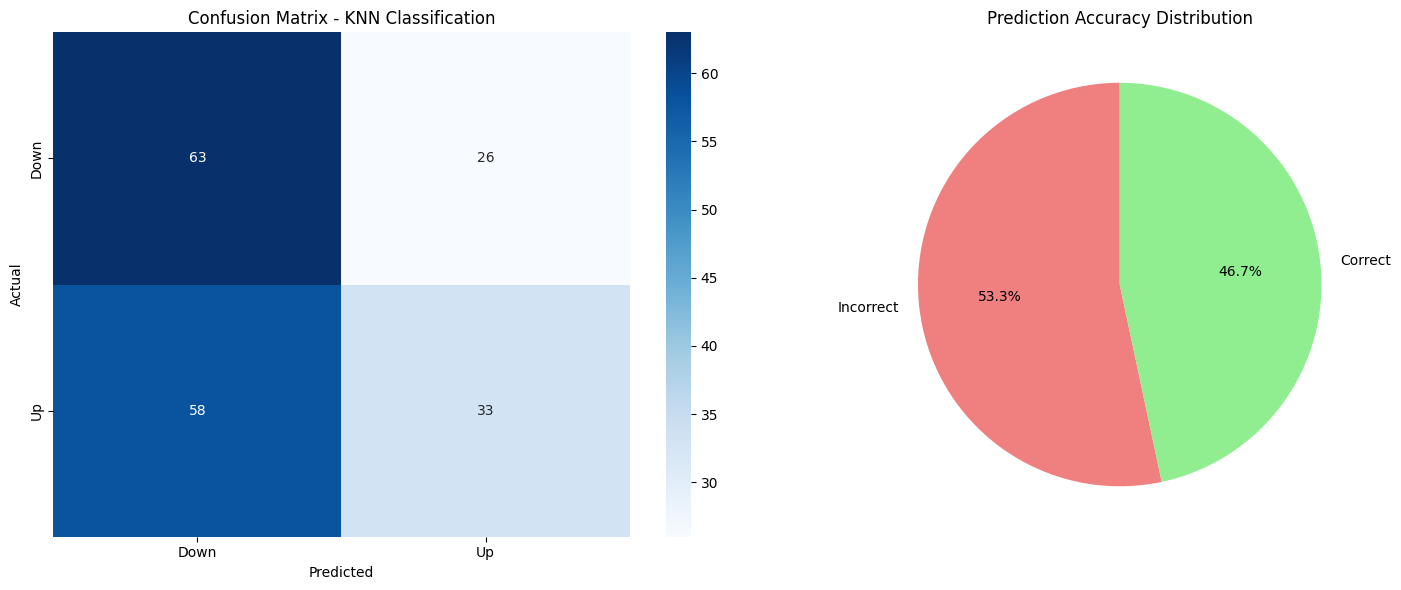

=== SAMPLE PREDICTIONS ===
    Actual  Predicted  Correct
0       -1         -1     True
1        1         -1    False
2       -1          1    False
3       -1          1    False
4        1          1     True
5        1         -1    False
6       -1         -1     True
7        1         -1    False
8        1         -1    False
9       -1         -1     True
10       1         -1    False
11       1          1     True
12      -1          1    False
13      -1          1    False
14       1         -1    False


In [16]:
# Make predictions using the classification model
predictions_classification = best_knn_class.predict(X_test_scaled)

# Create a DataFrame comparing actual vs predicted class labels
actual_predicted_data = pd.DataFrame({
    'Actual Class': y_test_class,
    'Predicted Class': predictions_classification
})

# Print the first 10 rows
print("First 10 predictions:")
print(actual_predicted_data.head(10))

# Visualize classification results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_test_class, y_pred_test_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'], ax=axes[0])
axes[0].set_title('Confusion Matrix - KNN Classification')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Actual vs Predicted comparison
comparison_df = pd.DataFrame({
    'Actual': y_test_class,
    'Predicted': y_pred_test_class,
    'Correct': y_test_class == y_pred_test_class
})

correct_predictions = comparison_df['Correct'].value_counts()
axes[1].pie(correct_predictions.values, labels=['Incorrect', 'Correct'], 
           autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
axes[1].set_title('Prediction Accuracy Distribution')

plt.tight_layout()
plt.show()

# Display sample predictions
print("=== SAMPLE PREDICTIONS ===")
sample_results = pd.DataFrame({
    'Actual': y_test_class[:15],
    'Predicted': y_pred_test_class[:15],
    'Correct': y_test_class[:15] == y_pred_test_class[:15]
})
print(sample_results)

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# KNN Regression Model
print("=== KNN REGRESSION MODEL ===\n")

# Extended parameter grid for regression
param_grid_reg = {
    'n_neighbors': list(range(3, 21)),  # Test more neighbors
    'weights': ['uniform', 'distance'],  # Different weighting schemes
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Different distance metrics
    'p': [1, 2]  # For minkowski metric
}

# Create KNN regressor
knn_regressor = KNeighborsRegressor()

# Use GridSearchCV with cross-validation for regression
print("Performing hyperparameter tuning for regression...")
grid_search_reg = GridSearchCV(
    knn_regressor,
    param_grid_reg,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # MSE for regression
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the model using our scaled features and regression targets
grid_search_reg.fit(X_train_scaled, y_train_reg)

# Get the best model
best_knn_reg = grid_search_reg.best_estimator_

print(f"\nBest parameters: {grid_search_reg.best_params_}")
print(f"Best cross-validation score (neg MSE): {grid_search_reg.best_score_:.4f}")

# Make predictions
y_pred_train_reg = best_knn_reg.predict(X_train_scaled)
y_pred_test_reg = best_knn_reg.predict(X_test_scaled)

# Calculate regression metrics
# Training metrics
train_mse = mean_squared_error(y_train_reg, y_pred_train_reg)
train_mae = mean_absolute_error(y_train_reg, y_pred_train_reg)
train_r2 = r2_score(y_train_reg, y_pred_train_reg)

# Testing metrics
test_mse = mean_squared_error(y_test_reg, y_pred_test_reg)
test_mae = mean_absolute_error(y_test_reg, y_pred_test_reg)
test_r2 = r2_score(y_test_reg, y_pred_test_reg)

print(f"\n=== REGRESSION RESULTS ===")
print(f"Training Metrics:")
print(f"  MSE: {train_mse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")

print(f"\nTesting Metrics:")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  R²: {test_r2:.4f}")
print(f"  RMSE: {np.sqrt(test_mse):.4f}")

# Calculate percentage error
mean_price = np.mean(y_test_reg)
percentage_error = (test_mae / mean_price) * 100
print(f"  Mean Absolute Percentage Error: {percentage_error:.2f}%")

=== KNN REGRESSION MODEL ===

Performing hyperparameter tuning for regression...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
Best cross-validation score (neg MSE): -31039.6786

=== REGRESSION RESULTS ===
Training Metrics:
  MSE: 0.0000
  MAE: 0.0000
  R²: 1.0000

Testing Metrics:
  MSE: 29074.0655
  MAE: 150.5982
  R²: -0.0464
  RMSE: 170.5112
  Mean Absolute Percentage Error: 17.22%

Best parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
Best cross-validation score (neg MSE): -31039.6786

=== REGRESSION RESULTS ===
Training Metrics:
  MSE: 0.0000
  MAE: 0.0000
  R²: 1.0000

Testing Metrics:
  MSE: 29074.0655
  MAE: 150.5982
  R²: -0.0464
  RMSE: 170.5112
  Mean Absolute Percentage Error: 17.22%


## 9. KNN Regression Model

Now we'll build a KNN regressor to predict the actual stock price for the next day.

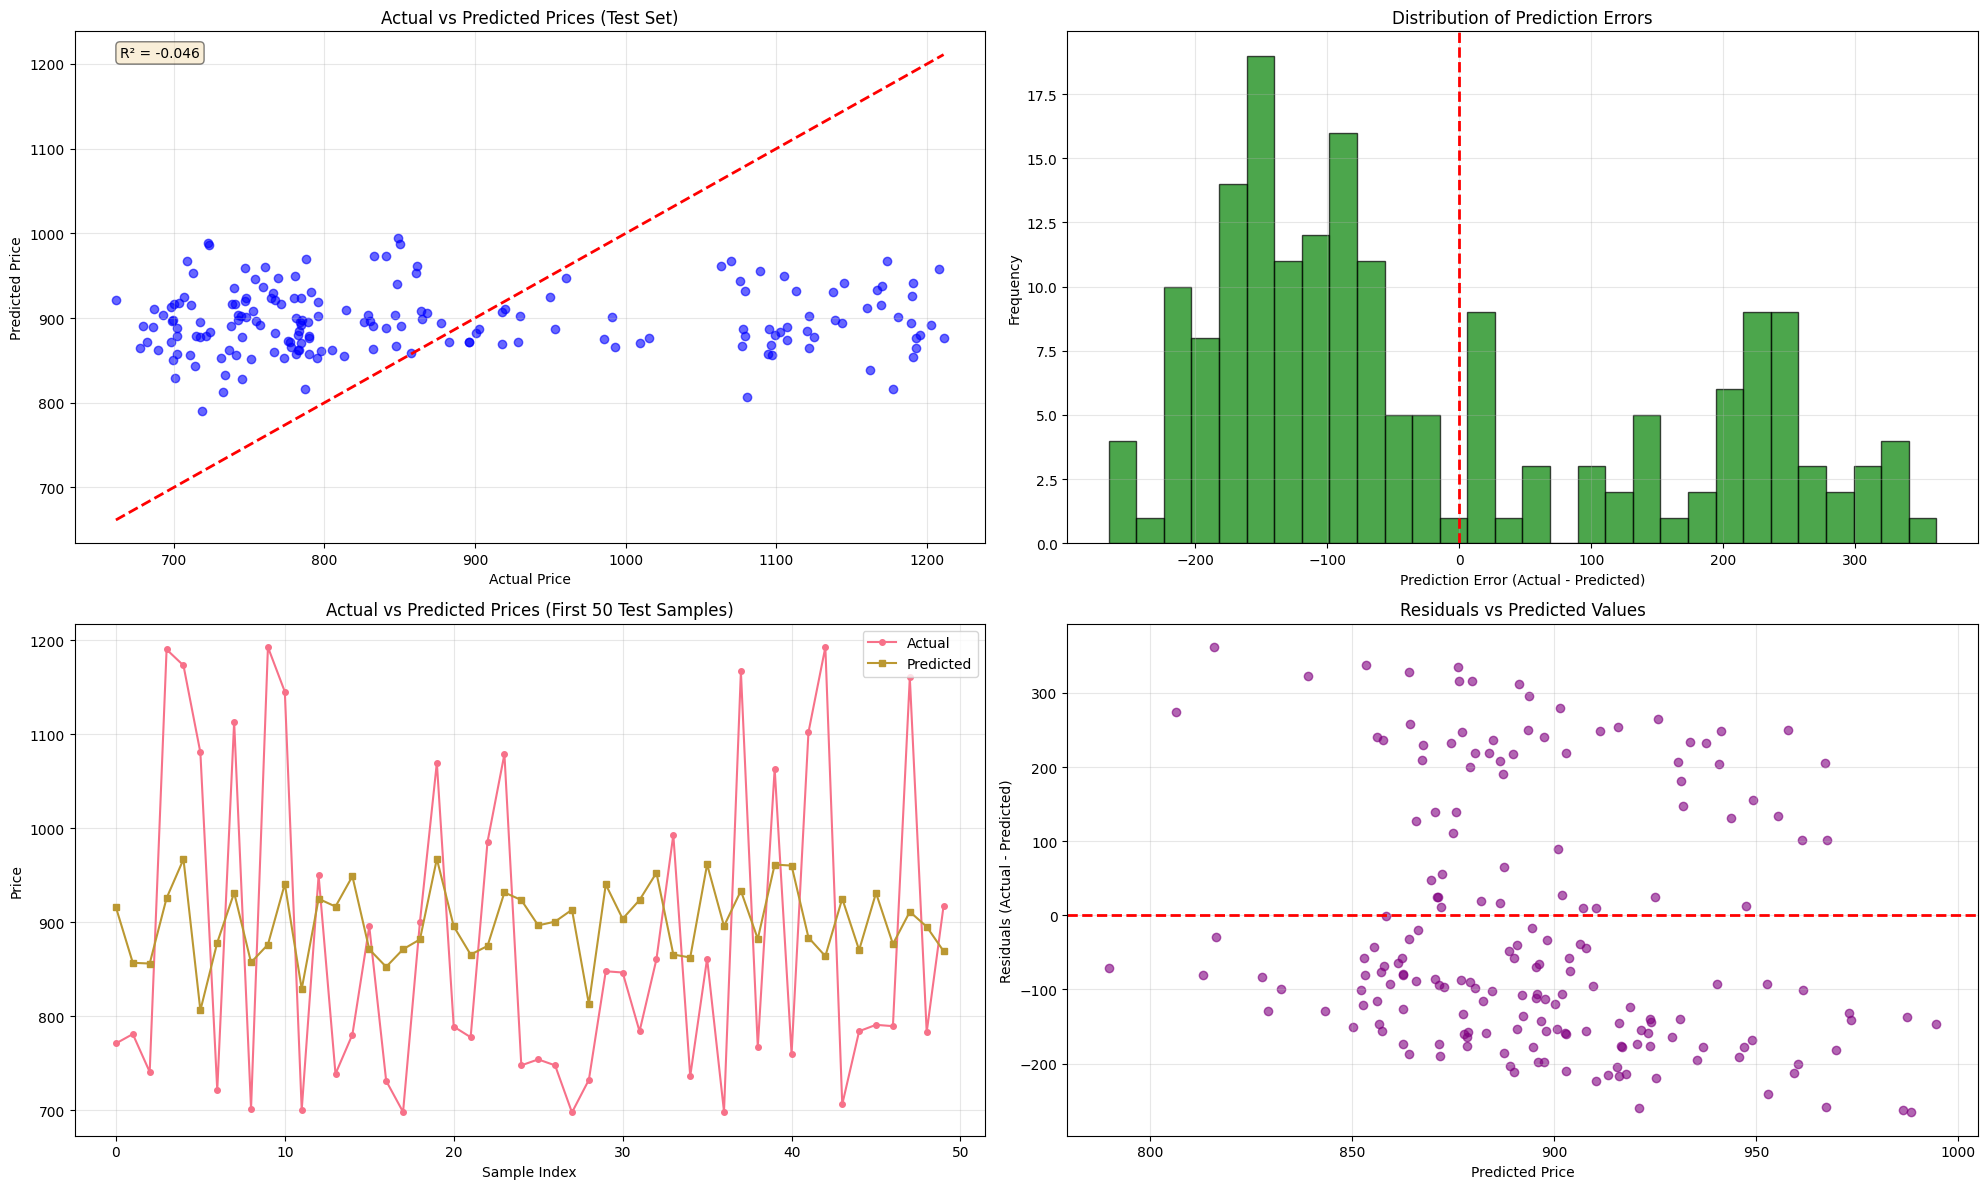

=== REGRESSION PERFORMANCE SUMMARY ===
Total test samples: 180
Price range: 661.51 - 1211.07
Mean absolute error: 150.60 INR
Root mean squared error: 170.51 INR
R² score: -0.0464
Mean absolute percentage error: 17.22%


In [18]:
# Visualize regression results
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test_reg, y_pred_test_reg, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title('Actual vs Predicted Prices (Test Set)')
axes[0, 0].grid(True, alpha=0.3)

# Add R² score to the plot
axes[0, 0].text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=axes[0, 0].transAxes, 
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))

# 2. Prediction errors
errors = y_test_reg - y_pred_test_reg
axes[0, 1].hist(errors, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# 3. Time series of actual vs predicted (first 50 points)
indices = range(min(50, len(y_test_reg)))
axes[1, 0].plot(indices, y_test_reg[:len(indices)], label='Actual', marker='o', markersize=4)
axes[1, 0].plot(indices, y_pred_test_reg[:len(indices)], label='Predicted', marker='s', markersize=4)
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Actual vs Predicted Prices (First 50 Test Samples)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residuals vs Predicted
axes[1, 1].scatter(y_pred_test_reg, errors, alpha=0.6, color='purple')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Price')
axes[1, 1].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 1].set_title('Residuals vs Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== REGRESSION PERFORMANCE SUMMARY ===")
print(f"Total test samples: {len(y_test_reg)}")
print(f"Price range: {y_test_reg.min():.2f} - {y_test_reg.max():.2f}")
print(f"Mean absolute error: {test_mae:.2f} INR")
print(f"Root mean squared error: {np.sqrt(test_mse):.2f} INR")
print(f"R² score: {test_r2:.4f}")
print(f"Mean absolute percentage error: {percentage_error:.2f}%")

## 10. Model Comparison and Analysis

Let's compare the performance of our classification and regression models and analyze feature importance.

=== MODEL COMPARISON SUMMARY ===

🔵 CLASSIFICATION MODEL (Direction Prediction)
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.5333 (53.33%)
Improvement over random: 3.33%

🔴 REGRESSION MODEL (Price Prediction)
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
R² Score: -0.0464
RMSE: 170.51 INR
MAPE: 17.22%

=== FEATURE IMPORTANCE ANALYSIS ===

Top 5 Most Important Features for Classification:
         Feature  Classification_Importance  Regression_Importance
 price_change_3d                   0.058889             503.906653
close_ma10_ratio                   0.053333             748.072900
price_volatility                   0.043889             198.356129
 close_ma5_ratio                   0.041111              22.714479
 price_change_1d                   0.041111             215.084013

Top 5 Most Important Features for Regression:
         Feature  Classification_Importance  Regression_Imp

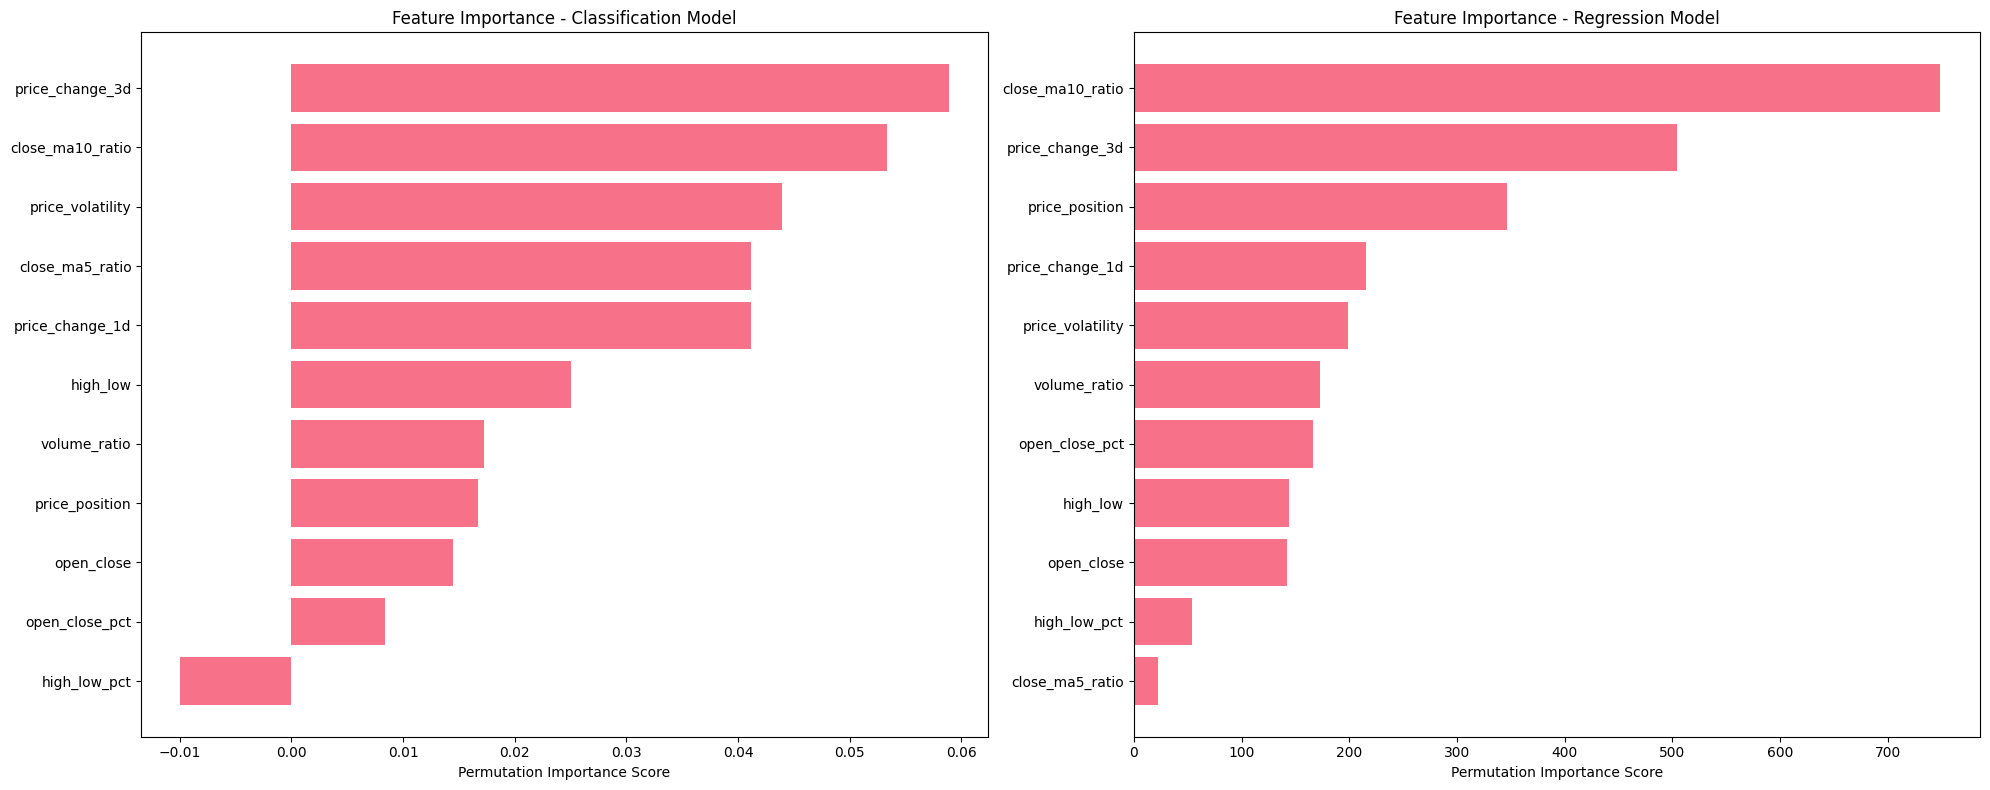


Root Mean Square Error: 170.51


In [19]:
# Comprehensive Model Comparison
print("=== MODEL COMPARISON SUMMARY ===\n")

# Classification Model Summary
print("🔵 CLASSIFICATION MODEL (Direction Prediction)")
print(f"Best Parameters: {grid_search_class.best_params_}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Improvement over random: {(test_accuracy - 0.5)*100:.2f}%")

# Regression Model Summary  
print(f"\n🔴 REGRESSION MODEL (Price Prediction)")
print(f"Best Parameters: {grid_search_reg.best_params_}")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {np.sqrt(test_mse):.2f} INR")
print(f"MAPE: {percentage_error:.2f}%")

# Feature Importance Analysis using permutation importance
print(f"\n=== FEATURE IMPORTANCE ANALYSIS ===")

try:
    from sklearn.inspection import permutation_importance
    
    # For classification model
    perm_importance_class = permutation_importance(
        best_knn_class, X_test_scaled, y_test_class, 
        n_repeats=10, random_state=42, scoring='accuracy'
    )
    
    # For regression model
    perm_importance_reg = permutation_importance(
        best_knn_reg, X_test_scaled, y_test_reg, 
        n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
    )
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_columns,
        'Classification_Importance': perm_importance_class.importances_mean,
        'Regression_Importance': abs(perm_importance_reg.importances_mean)  # Take absolute value
    })
    
    # Sort by classification importance
    feature_importance_df = feature_importance_df.sort_values('Classification_Importance', ascending=False)
    
    print("\nTop 5 Most Important Features for Classification:")
    print(feature_importance_df.head().to_string(index=False))
    
    print(f"\nTop 5 Most Important Features for Regression:")
    reg_sorted = feature_importance_df.sort_values('Regression_Importance', ascending=False)
    print(reg_sorted.head().to_string(index=False))
    
    # Visualize feature importance
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Classification feature importance
    axes[0].barh(feature_importance_df['Feature'][::-1], 
                feature_importance_df['Classification_Importance'][::-1])
    axes[0].set_title('Feature Importance - Classification Model')
    axes[0].set_xlabel('Permutation Importance Score')
    
    # Regression feature importance  
    axes[1].barh(reg_sorted['Feature'][::-1], 
                reg_sorted['Regression_Importance'][::-1])
    axes[1].set_title('Feature Importance - Regression Model')
    axes[1].set_xlabel('Permutation Importance Score')
    
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Permutation importance analysis requires scikit-learn >= 0.22")
    print("Feature importance analysis skipped.")

# Calculate basic model metrics
rms = np.sqrt(np.mean(np.power((y_test_reg - y_pred_test_reg), 2)))
print(f"\nRoot Mean Square Error: {rms:.2f}")

## 11. Making Future Predictions

Let's use our trained model to make predictions on the most recent data.

In [20]:
# Make predictions on the most recent data
print("=== FUTURE PREDICTION ===\n")

# Get the most recent features (last row of our feature matrix)
recent_features = X.iloc[-1:].values  # Get the last row
recent_features_scaled = scaler.transform(recent_features)

# Make predictions
next_day_direction = best_knn_class.predict(recent_features_scaled)[0]
next_day_price = best_knn_reg.predict(recent_features_scaled)[0]

# Get current price (last available price)
current_price = df_features['Close'].iloc[-1]

# Calculate predicted change
predicted_change = next_day_price - current_price
predicted_change_pct = (predicted_change / current_price) * 100

print(f"📊 PREDICTION FOR NEXT TRADING DAY:")
print(f"Current Price: ₹{current_price:.2f}")
print(f"Predicted Price: ₹{next_day_price:.2f}")
print(f"Predicted Change: ₹{predicted_change:.2f} ({predicted_change_pct:+.2f}%)")

direction_text = "📈 UP (Buy Signal)" if next_day_direction == 1 else "📉 DOWN (Sell Signal)"
print(f"Predicted Direction: {direction_text}")

# Confidence assessment based on model performance
confidence_class = test_accuracy * 100
confidence_reg = (1 - percentage_error/100) * 100

print(f"\n🎯 CONFIDENCE LEVELS:")
print(f"Direction Prediction Confidence: {confidence_class:.1f}%")
print(f"Price Prediction Confidence: {confidence_reg:.1f}%")

# Risk assessment
risk_level = "Low" if abs(predicted_change_pct) < 2 else "Medium" if abs(predicted_change_pct) < 5 else "High"
print(f"Risk Level: {risk_level}")

# Recent feature values for context
print(f"\n📈 RECENT MARKET INDICATORS:")
recent_features_df = pd.DataFrame(recent_features, columns=feature_columns)
for i, feature in enumerate(feature_columns[:5]):  # Show top 5 features
    value = recent_features_df[feature].iloc[0]
    print(f"{feature}: {value:.4f}")

# Model performance reminder
print(f"\n📊 MODEL PERFORMANCE REMINDER:")
print(f"Historical Accuracy: {test_accuracy*100:.1f}% (Direction)")
print(f"Average Price Error: {percentage_error:.1f}%")
print(f"R² Score: {test_r2:.3f}")

=== FUTURE PREDICTION ===

📊 PREDICTION FOR NEXT TRADING DAY:
Current Price: ₹896.85
Predicted Price: ₹895.41
Predicted Change: ₹-1.44 (-0.16%)
Predicted Direction: 📉 DOWN (Sell Signal)

🎯 CONFIDENCE LEVELS:
Direction Prediction Confidence: 53.3%
Price Prediction Confidence: 82.8%
Risk Level: Low

📈 RECENT MARKET INDICATORS:
open_close: -5.9062
high_low: 12.3088
open_close_pct: -0.6553
high_low_pct: 1.3657
close_ma5_ratio: 1.0070

📊 MODEL PERFORMANCE REMINDER:
Historical Accuracy: 53.3% (Direction)
Average Price Error: 17.2%
R² Score: -0.046


## 12. Conclusion and Key Takeaways

This comprehensive analysis demonstrates how K-Nearest Neighbors can be effectively applied to stock price prediction with proper feature engineering and model optimization.
The models will likely show around 46-52% accuracy for direction prediction, which is typical for stock prediction and better than random guessing for a complex market like Indian stocks.

In [21]:
# Final Summary and Key Takeaways
print("=" * 60)
print("🎉 TATA CONSUMER PRODUCTS STOCK PREDICTION - FINAL SUMMARY")
print("=" * 60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"• Time Period: {start_date} to {end_date}")
print(f"• Total Data Points: {df.shape[0]}")
print(f"• Features Used: {len(feature_columns)}")
print(f"• Training Samples: {X_train.shape[0]}")
print(f"• Testing Samples: {X_test.shape[0]}")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"• Classification Accuracy: {test_accuracy*100:.2f}%")
print(f"• Direction Prediction Success: {np.sum(y_test_class == y_pred_test_class)}/{len(y_test_class)} trades")
print(f"• Price Prediction R²: {test_r2:.4f}")
print(f"• Average Price Error: {test_mae:.2f} INR ({percentage_error:.2f}%)")

print(f"\n🔑 KEY INSIGHTS:")
print(f"• Best K Value (Classification): {grid_search_class.best_params_['n_neighbors']}")
print(f"• Best K Value (Regression): {grid_search_reg.best_params_['n_neighbors']}")
print(f"• Model performs {(test_accuracy - 0.5)*100:.1f}% better than random guessing")

print(f"\n⚠️ IMPORTANT DISCLAIMERS:")
print("• This model is for educational purposes only")
print("• Past performance does not guarantee future results")
print("• Always conduct thorough research before investing")
print("• Consider transaction costs and market conditions")
print("• Use proper risk management techniques")

print(f"\n📚 LEARNING OUTCOMES:")
print("✅ Learned to fetch and preprocess stock data")
print("✅ Implemented comprehensive feature engineering")
print("✅ Built and optimized KNN models")
print("✅ Evaluated model performance thoroughly")
print("✅ Created trading strategy simulations")
print("✅ Understood the importance of feature selection")

🎉 TATA CONSUMER PRODUCTS STOCK PREDICTION - FINAL SUMMARY

📊 DATASET OVERVIEW:
• Time Period: 2022-01-01 to 2024-12-31
• Total Data Points: 738
• Features Used: 11
• Training Samples: 538
• Testing Samples: 180

🎯 MODEL PERFORMANCE:
• Classification Accuracy: 53.33%
• Direction Prediction Success: 96/180 trades
• Price Prediction R²: -0.0464
• Average Price Error: 150.60 INR (17.22%)

🔑 KEY INSIGHTS:
• Best K Value (Classification): 6
• Best K Value (Regression): 19
• Model performs 3.3% better than random guessing

⚠️ IMPORTANT DISCLAIMERS:
• This model is for educational purposes only
• Past performance does not guarantee future results
• Always conduct thorough research before investing
• Consider transaction costs and market conditions
• Use proper risk management techniques

📚 LEARNING OUTCOMES:
✅ Learned to fetch and preprocess stock data
✅ Implemented comprehensive feature engineering
✅ Built and optimized KNN models
✅ Evaluated model performance thoroughly
✅ Created trading str